In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
plt.style.use('fivethirtyeight')

from wordcloud import WordCloud, STOPWORDS
from twython import Twython
import keys #twitter keys: APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import string
from collections import defaultdict

import gensim
from gensim import corpora

import requests

C:\Anaconda3\lib\site-packages\gensim\utils.py:843: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
%load_ext watermark
%watermark -d -v -m -p pandas,scipy,matplotlib,twython,nltk,wordCloud,gensim

2017-01-03 

CPython 3.5.1
IPython 4.2.0

pandas 0.18.1
scipy 0.17.1
matplotlib 1.5.1
twython 3.4.0
nltk 3.2.1
wordCloud 1.2.1
gensim 0.13.4

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [3]:
# twython auth
twitter = Twython(keys.APP_KEY, keys.APP_SECRET,keys.OAUTH_TOKEN, keys.OAUTH_TOKEN_SECRET)

In [4]:
#get more than 200 tweets: http://www.craigaddyman.com/mining-all-tweets-with-python/

In [5]:
# init empty lists to save tweets and metadata
user_ids, user_names, texts , creation, retweets ,favorites,lenguage, retweet, retweet_from, in_reply, coordinates = ([] for i in range(11))
# get following IDs and NAMES (can get more info of users if needed!)
following_ids = [] # to save ids
following_names = {} # dictinary key:user_id, value: user_name
user_location = []
following = twitter.get_friends_ids()["ids"]
print("Number of following: ",len(following))

# get 200 tweets and metadata from each friend (can get more metadata if needed!)
for user_id in following:
    tweets200 = twitter.get_user_timeline(user_id=user_id,count=200)
    for t in tweets200:
        user_ids.append(user_id)
        #user_names.append(following_names[user_id])
        texts.append(t["text"])
        creation.append(t["created_at"])
        retweets.append(t["retweet_count"])
        favorites.append(t["favorite_count"])
        lenguage.append(t["lang"])
        #coordinates.append(t["coordinates"])
        in_reply.append(t['in_reply_to_screen_name'])
        retweet.append(('retweeted_status') in t)
        if ('retweeted_status') in t:
            retweet_from.append(t['retweeted_status']['user']['name'])
        else:
            retweet_from.append("N/A")
    #get user location
    user_location.append(twitter.show_user(user_id=user_id)["location"])

Number of following:  416


In [6]:
# create final DataFrame
mytweets = pd.DataFrame({'user_id':user_ids,#'user_name':user_names,
                         'text':texts ,'retweet': retweet, 'creation':creation,
                         'retweets':retweets , 'favorites':favorites, 
                         'lenguage':lenguage,'retweet_from': retweet_from,
                         'in_reply':in_reply})

mytweets["in_reply"] = mytweets["in_reply"].map(lambda x: "None" if x is None else x) # fix in_replay column None type to "None"

In [7]:
# checks
print("size:", mytweets.shape, "\n------------------------") #size
print(mytweets.isnull().sum()) #column names $missing values 
print("\nreplies and retweets at the same time:",end=" ")
print(mytweets[(mytweets["in_reply"]!="None") & (mytweets["retweet"]==True)].size)

size: (78250, 9) 
------------------------
creation        0
favorites       0
in_reply        0
lenguage        0
retweet         0
retweet_from    0
retweets        0
text            0
user_id         0
dtype: int64

replies and retweets at the same time: 0


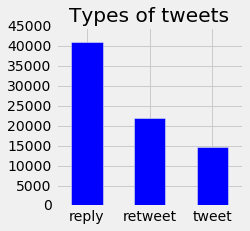

In [8]:
# Home many of all tweets are regular, tweeet, reply
def tweet_type(row):
    if row.retweet == True:
        return "retweet"
    elif row.in_reply == "None":
        return "reply"
    else:
        return "tweet"
# are there any replies and retweets?
a = mytweets.apply(tweet_type,1)
fig=plt.figure(figsize=(3,3))
a.value_counts().plot(kind='bar', color='blue')
plt.title("Types of tweets")
plt.xticks(rotation=0)
plt.show()
del a

In [12]:
mytweets.head()

,creation,favorites,in_reply,lenguage,retweet,retweet_from,retweets,text,user_id
0,Tue Jan 03 19:04:40 +0000 2017,0,None,en,False,N/A,0,Come to the #Boston Algorithms meetup tomorrow...,710329346234318848
1,Tue Jan 03 16:04:44 +0000 2017,0,None,en,False,N/A,0,Are you going to the Women for Women (bloggers...,710329346234318848
2,Mon Jan 02 23:44:11 +0000 2017,0,None,en,False,N/A,0,Who's going to the @bostonphp meetup on Saturd...,710329346234318848
3,Mon Jan 02 21:38:14 +0000 2017,0,None,en,False,N/A,0,Who else is looking forward to #Boston #Ruby G...,710329346234318848
4,Mon Jan 02 19:29:19 +0000 2017,0,None,en,False,N/A,0,Check out the @CodeForBoston meetup tomorrow t...,710329346234318848


In [10]:
stop = stopwords.words('english') + stopwords.words('spanish')
other_stop = ['via','&amp;', 'now','one','thing','us', 'will',"it's",'it',"i'm","u","you","yet", "say"
             "much", "gt", "new", "us", "also","don't", ]
stop = set(stop + other_stop)
exclude = set(string.punctuation)
def clean_tweets (tweets_string, puntuation=True, lemma=False):
    # gets a string with all tweets and remove RT, links and ids (start with @)
    words_clean = " ".join([word for word in tweets_string.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
    words_clean = " ".join([i for i in words_clean.lower().split() if i not in stop])
    if puntuation:
        words_clean = "".join(ch for ch in words_clean if ch not in exclude)
    if lemma :    
        words_clean = " ".join(lemma.lemmatize(word) for word in words_clean.split() if type(world) is str)
    return words_clean
    
# words of ALL TWEETS
words = clean_tweets(' '.join(mytweets['text']))
# words of ALL REGULAR TWEETS 
words_regular = clean_tweets(' '.join(mytweets[(mytweets["in_reply"]=="None") & (mytweets["retweet"]==False)].text))
# words of ONLY RETWEETS
words_rt = clean_tweets(' '.join(mytweets[mytweets["retweet"] == True].text))
# words of ONLY REPLIES
words_reply = clean_tweets(' '.join(mytweets[mytweets["in_reply"] != "None"].text))

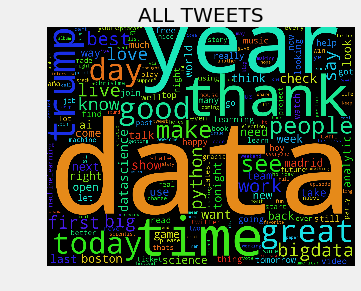

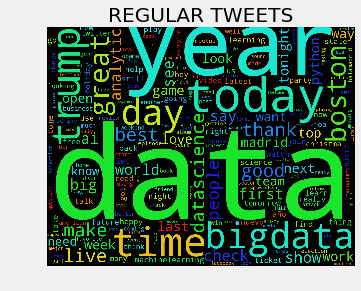

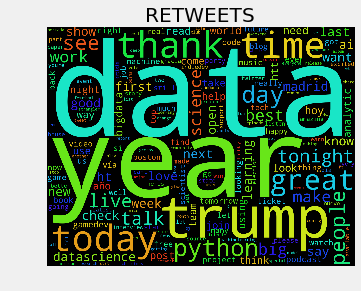

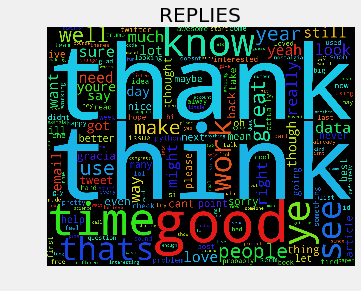

In [13]:
#more_stopwords = {'new', 'amp', 'will', 'yet','via','now','one','thing','us','say','aslo','much','gt'}
#STOPWORDS = STOPWORDS.union(more_stopwords)

# wordcloud 
title = ["ALL TWEETS", "REGULAR TWEETS","RETWEETS","REPLIES"]
i=0 # for plot titles
for data in [words, words_regular, words_rt, words_reply]:  
    #generate wordcloud
    wordcloud = WordCloud(#stopwords=STOPWORDS,
                          background_color='black',
                          width=1800,
                          height=1400
                         ).generate(data)
    #print wordcloud
    plt.imshow(wordcloud)
    plt.title(title[i])
    plt.axis('off')
    plt.show()
    i+=1

In [14]:
def leaders(xs, top=20):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]

# location of followings
locations = leaders(user_location,1000) #all locations

In [15]:
list_add=[] # list of lists [localization, number_of_times, latitude, longitude]

for loc in locations:
    la=[loc[0], loc[1]]
    fix_add = loc[0].replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        coordinates = resp_json_payload['results'][0]['geometry']['location']
        la.append(str(coordinates['lat'])+" "+str(coordinates['lng']))
        list_add.append(la)
    except:
        continue
location_df = pd.DataFrame(list_add, columns=["location","count", "coordinates"])
location_plot = location_df.groupby("coordinates")["count"].sum()
location_plot.sort_values(inplace=True)

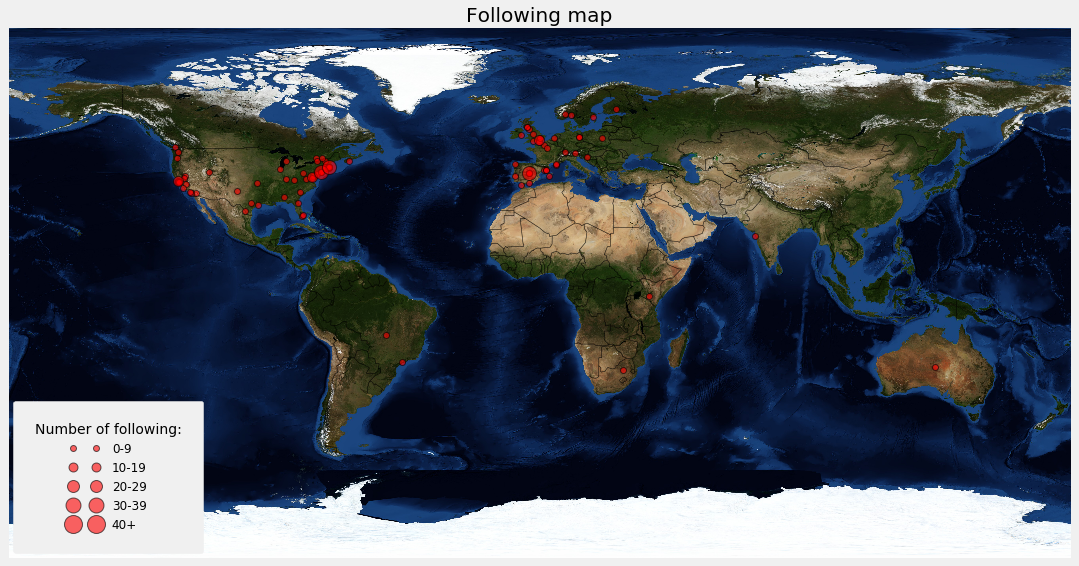

In [16]:
#map
fig = plt.figure(figsize=(17,22))
m = Basemap()
m.bluemarble() #m.etopo()
m.drawcountries()

# cities
marker_size = [6,10,14,19,24]

for loc in location_plot.index:
    lat = loc.split()[0]
    lon = loc.split()[1]
    # bin 5 for clusters
    count = int(location_plot.loc[loc]/10)
    if count > 4: count=4
    m.plot(lon,lat,'bo',markersize=marker_size[count], color='red',alpha=0.6,markeredgecolor='black',
         markeredgewidth=1) 

labels = ['0-9', '10-19', '20-29', '30-39', '40+']

leg = plt.legend(labels, ncol=1,fontsize=12, handlelength=2.5, loc="lower left",
                 borderpad = 1.8,handletextpad=1, title='Number of following:', scatterpoints = 1)
leg.legendHandles[0]._legmarker.set_markersize(6)
leg.legendHandles[1]._legmarker.set_markersize(9)
leg.legendHandles[2]._legmarker.set_markersize(12)
leg.legendHandles[3]._legmarker.set_markersize(15)
leg.legendHandles[4]._legmarker.set_markersize(18)


plt.title("Following map")
plt.show()

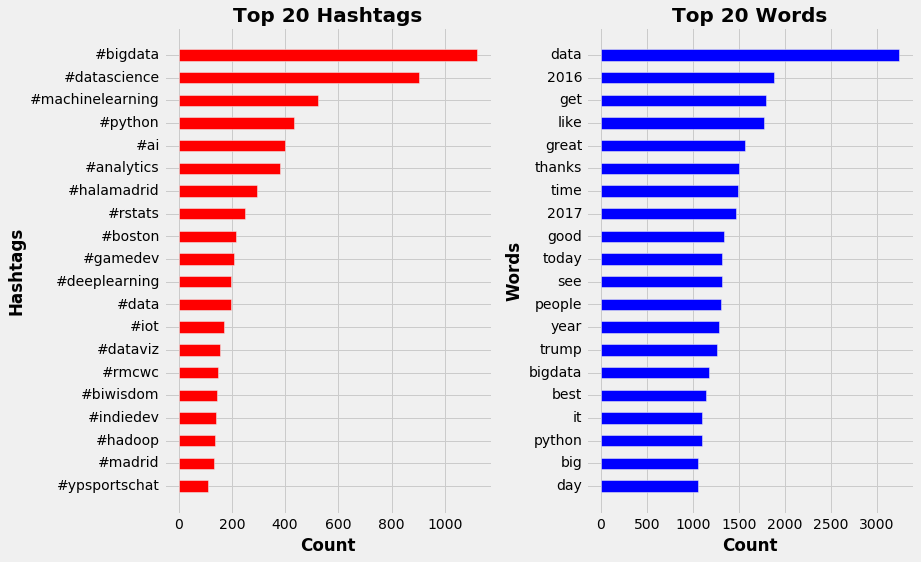

In [17]:
# hastags
words = clean_tweets(' '.join(mytweets['text']), False) # puntuation is False so we don't delete hastags
top10hash = pd.DataFrame(leaders([x for x in words.split() if x[0]=='#' and x!='#rt']),columns=["hashtag", "count"])
#words
words = clean_tweets(' '.join(mytweets['text'])) # puntuation is False so we don't delete hastags
top10words = pd.DataFrame(leaders([x for x in words.split()]), columns=["word", "count"])

fig = plt.figure(figsize=(13,8))
# hashtags barh plot
bar_heights =  top10hash['count'].values
bar_positions = np.arange(len(bar_heights))  
tick_positions = range(0,20) 

ax1 = fig.add_subplot(1,2,1)
ax1.barh(bar_positions, bar_heights, 0.5, align='center', color='red')
ax1.set_yticks(tick_positions)
ax1.set_yticklabels(top10hash['hashtag'].values,)
ax1.set_yticks(tick_positions)
ax1.set_xlabel("Count",fontweight = 'bold')
ax1.set_ylabel("Hashtags",fontweight = 'bold')
ax1.set_title("Top 20 Hashtags",fontweight = 'bold', size=20)
plt.gca().invert_yaxis()
plt.margins(0.05)

#words barh plot
bar_heights =  top10words['count'].values
bar_positions = np.arange(len(bar_heights))  
tick_positions = range(0,20) 

ax2 = fig.add_subplot(1,2,2)
ax2.barh(bar_positions, bar_heights, 0.5, align='center', color='blue')
ax2.set_yticks(tick_positions)
ax2.set_yticklabels(top10words['word'].values,)
ax2.set_yticks(tick_positions)
ax2.set_xlabel("Count",fontweight = 'bold')
ax2.set_ylabel("Words",fontweight = 'bold')
ax2.set_title("Top 20 Words",fontweight = 'bold', size=20 )
plt.gca().invert_yaxis()
plt.margins(0.05)

plt.tight_layout()
plt.show()

In [ ]:
#LDA
listoft = mytweets['text'].tolist()
list_clean_tweets = [clean_tweets(x,puntuation=True, lemma=False) for x in listoft]
doc_clean = [x.split() for x in list_clean_tweets]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)
#clean_tweets(' '.join(mytweets['text']))
listoft = mytweets['text'].tolist()
list_clean_tweets = [clean_tweets(x,puntuation=True, lemma=True) for x in listoft]